# Timeseries - Part (3/3) - Predicting the future

#### (continued from Part (2/3) - Running first experiments) 

At the last stage, we were able to make some models that could predict the training set. However what we actually want to do is predict new, unseen data. Let's get to it! 

Imports: 

In [1]:
import pandas as pd 
% matplotlib inline 
from matplotlib import pyplot as plt 

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns

import warnings # this is to suppress an annoying warning from sklearn 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('seaborn')

Getting the raw data:

In [2]:
train = pd.read_csv('../data/sales_data.csv', 
                    low_memory=False)  # this is used to ensure that it checks the types properly 

We will use the following functions a lot: 

In [5]:
def prepare_index(df):   # <--- take any raw data, and get the index in order 
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'],      
                                   format='%Y-%m-%d')   
    df.set_index(['Date', 'Store'], inplace=True)      
    df.sort_index(inplace=True)
    return df

def prepare_features(df):   # <--- Feature builder. We will edit this bit a lot, to iterate. 
    df = df.copy()
    df['Previous day sales'] = df.groupby('Store')['Sales'].shift(1)    
    df['Sales 6 days before'] = df.groupby('Store')['Sales'].shift(6)
    
    df.dropna(inplace=True)
    return df

def prepare_target(df):   # <--- get the target ready for the training set. Not needed for the test set.
    df = df.copy()
    df['Next day sales'] = df.groupby('Store')['Sales'].shift(-1)
    df.dropna(inplace=True)
    return df

Let's apply all this to the training set: 

In [6]:
# first the index: 
train_with_prepared_index = prepare_index(train)
# now building some extra features 
train_with_prepared_features = prepare_features(train_with_prepared_index)
# and finally prepare the target (because we'll need this to train)
train_fully_prepared = prepare_target(train_with_prepared_features)

Let's get an idea of what the data looks like: 

In [7]:
print('Training data:')
print('Format:   ', train.shape)
print('Min date: ', train_with_prepared_index.index.get_level_values('Date').min())
print('Max date: ', train_with_prepared_index.index.get_level_values('Date').max())
print('\nTraining data after building features:')
print('Format:   ', train_with_prepared_features.shape)
print('Min date: ', train_with_prepared_features.index.get_level_values('Date').min())
print('Max date: ', train_with_prepared_features.index.get_level_values('Date').max())
print('\nTraining data after adding the target:')
print('Format:   ', train_fully_prepared.shape)
print('Min date: ', train_fully_prepared.index.get_level_values('Date').min())
print('Max date: ', train_fully_prepared.index.get_level_values('Date').max())

Training data:
Format:    (473922, 13)
Min date:  2013-01-01 00:00:00
Max date:  2015-05-29 00:00:00

Training data after building features:
Format:    (470574, 13)
Min date:  2013-01-07 00:00:00
Max date:  2015-05-29 00:00:00

Training data after adding the target:
Format:    (470016, 14)
Min date:  2013-01-07 00:00:00
Max date:  2015-05-28 00:00:00


### Now for fitting regressors! 

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error, r2_score

Let's make a small RF:  

In [9]:
rf = RandomForestRegressor(n_estimators=10, 
                      max_depth=10, 
                      n_jobs=-1)

Define our features (because we don't want to use the categoricals for now), and target:

In [10]:
features = [
    'Customers',
    'DayOfWeek',
    'Next day is Open',
    'Next day is SchoolHoliday',
    #'Next day is StateHoliday',
    'Next day is a Promo',
    'Open',
    'Previous day sales',
    'Promo',
    'Sales',
    'Sales 6 days before',
    'SchoolHoliday',
    #'StateHoliday'
]

target = 'Next day sales'

Fit the model: 

In [11]:
%%time 
rf.fit(X=train_fully_prepared[features], 
       y=train_fully_prepared[target]);

CPU times: user 17 s, sys: 227 ms, total: 17.2 s
Wall time: 6.81 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Let's get the day before the one we want to predict: 

In [12]:
last_day_we_have = pd.to_datetime(train['Date'],   # <--- notice this is the "raw" training set 
                                  format='%Y-%m-%d').max()

print(last_day_we_have)

2015-05-29 00:00:00


Let's get the data on that day: 

In [13]:
# note how we use train_with_prepared_features here, because train_fully_prepared does not have the last day
last_day_data = train_with_prepared_features.xs(last_day_we_have, 
                                                level='Date')

... and predict the sales on the next day! (remember, we didn't actually have a target for this day) 

In [14]:
last_day_data['Predictions for next day'] = rf.predict(last_day_data[features])

Quick glance: 

In [15]:
last_day_data[['Sales', 'Predictions for next day']].head()

,Sales,Predictions for next day
Store,,
1,4656,4345.712333
2,4541,2862.589966
3,7421,4816.565403
4,10529,10035.137425
6,5435,3251.757914


# How well did we do ?

Let's import some new data then! 

In [16]:
future = pd.read_csv('../data/sales_data_recent.csv', low_memory=False)

Do we have the next day? 

In [17]:
day_we_predicted = last_day_we_have + pd.offsets.Day(1)
print(day_we_predicted)

2015-05-30 00:00:00


In [18]:
future_prepared_index = prepare_index(future)

In [19]:
future_prepared_index.head()

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2015-05-30 1              6   5592        580     1      0            0   
           2              6   3447        513     1      0            0   
           3              6   4542        458     1      0            0   
           4              6  12187       1590     1      0            0   
           6              6   3756        394     1      0            0   

                  SchoolHoliday  Next day is SchoolHoliday  \
Date       Store                                             
2015-05-30 1                  0                          0   
           2                  0                          0   
           3                  0                          0   
           4                  0                          0   
           6                  0                          0   

                 Next day is StateHoliday  Next day is a Promo  \
Date       Store                                                 
2015-05-30 1                            0                    0   
           2                            0                    0   
           3                            0                    0   
           4                            0                    0   
           6                            0                    0   

                  Next day is Open  
Date       Store                    
2015-05-30 1                     0  
           2                     0  
           3                     0  
           4                     0  
           6                     0

Notice that we didn't create a target or the features. For now, we just care about the features.

In [20]:
new_day_data = future_prepared_index.xs(day_we_predicted, level='Date')

Now for a bit of Pandas magic: we're going to concatenate the two series, on the key Store, so that we can compare them. 

We only want the "`predictions for the next day`" (on "`last_day_data`" ) and the "`sales`" of the "`new_day_data`"

In [25]:
results = pd.concat([
           last_day_data['Predictions for next day'],
           new_day_data['Sales'], 
           ], 
          axis=1)

In [26]:
results.head(5)

,Predictions for next day,Sales
Store,,
1,4345.712333,5592
2,2862.589966,3447
3,4816.565403,4542
4,10035.137425,12187
6,3251.757914,3756


In [27]:
from sklearn.metrics import r2_score

In [28]:
r2_score(results['Sales'], results['Predictions for next day'])

0.86244996861490997

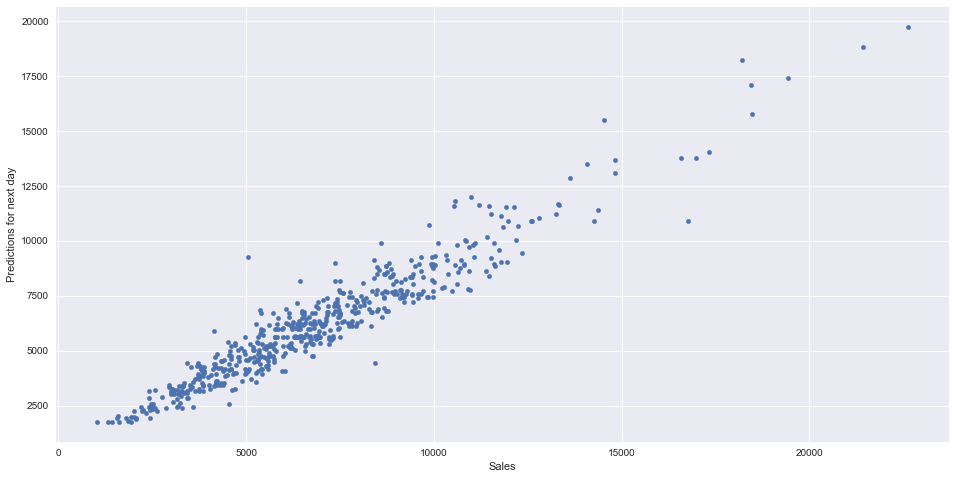

In [29]:
results.plot(kind='scatter', 
             x='Sales', 
             y='Predictions for next day', 
             figsize=(16, 8))

Great! Now by changing the feature builder and the models, we can try to do better. Obviously to discover these we need to do things in cross validation, because we can't keep looking at the test set, but we have all the tools we need! 